
# Week 8 — Track C: Multimodal Router (Florida — Hurricane Irma)

This Colab-friendly notebook implements a **lightweight multimodal router** that decides whether a user query should go to:
- **QA** (Florida Hurricane Irma local context),
- **Visualization** (matplotlib-only; no seaborn),
- **Speech** (Whisper STT + gTTS TTS; optional if libs not installed).

It includes:
- **Routing logic** (keywords + guardrails),
- **Unified API** (`route(query)`),
- **Trace logging** to `logs/router_traces.jsonl`,
- **≥ 5 test queries** with recorded outputs (plots/audio when available).


In [1]:
# [Optional] Uncomment in Colab if needed
!pip install pandas matplotlib gTTS openai-whisper SpeechRecognition


In [2]:
import os, json, time, uuid, re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

BASE = Path(".").resolve()
LOGS = BASE / "logs"
AUDIO_OUT = BASE / "audio_outputs"
VIS_OUT = BASE / "visual_outputs"
for d in [LOGS, AUDIO_OUT, VIS_OUT]:
    d.mkdir(exist_ok=True)

# --- Embedded Florida Hurricane Irma (2017) mini-dataset ---
start = datetime(2017, 9, 5)
dates = [start + timedelta(days=i) for i in range(8)]
df = pd.DataFrame({
    "date": dates,
    "wind_speed": [150, 155, 160, 165, 130, 120, 90, 60],
    "pressure":   [930, 925, 920, 915, 935, 945, 960, 980],
    "rainfall":   [1.2, 2.1, 3.4, 4.8, 7.9, 5.0, 2.3, 0.8],
    "storm_category": [5, 5, 5, 5, 4, 3, None, None],
})
df.head()


,date,wind_speed,pressure,rainfall,storm_category
0,2017-09-05,150,930,1.2,5.0
1,2017-09-06,155,925,2.1,5.0
2,2017-09-07,160,920,3.4,5.0
3,2017-09-08,165,915,4.8,5.0
4,2017-09-09,130,935,7.9,4.0



## QA Module — Florida Hurricane Irma (Local Context)


In [4]:
IRMA_PASSAGES = [
    {"title": "Overview", "text": (
        "Hurricane Irma was a powerful Cape Verde hurricane in 2017. "
        "It peaked at Category 5 with 185 mph sustained winds. "
        "Irma impacted the northern Leeward Islands, the Bahamas, Cuba, and Florida."
    ), "tags": ["irma","overview","2017","atlantic","category 5","winds"]},
    {"title": "Florida Landfalls and Timeline", "text": (
        "Irma made landfall in the Florida Keys near Cudjoe Key on September 10, 2017 as a Category 4 hurricane. "
        "Later the same day, it made a second Florida landfall at Marco Island as a Category 3, "
        "then tracked northward through the state, weakening but causing extensive impacts."
    ), "tags": ["florida","landfall","keys","cudjoe key","marco island","timeline"]},
    {"title": "Impacts in Florida", "text": (
        "Florida experienced destructive winds, storm surge flooding on both coasts, "
        "freshwater flooding from heavy rains, and massive power outages affecting millions."
    ), "tags": ["impacts","storm surge","flooding","power outages","evacuations"]},
    {"title": "Damages and Costs", "text": (
        "Losses from Irma were tens of billions of dollars, heavily concentrated in Florida. "
        "Housing, infrastructure, agriculture, and tourism sectors were affected."
    ), "tags": ["damages","costs","losses","billions","economy"]},
    {"title": "Preparedness and Lessons", "text": (
        "Lessons from Irma include the importance of early evacuation, hardened infrastructure, "
        "and better risk communication about surge, wind, and flooding."
    ), "tags": ["lessons","preparedness","evacuation","infrastructure","communication"]}
]

import re
def _norm(t:str)->str:
    return re.sub(r"\s+"," ", re.sub(r"[^a-z0-9\s]"," ", t.lower())).strip()

def retrieve_passages(query: str, k: int = 3):
    q = set(_norm(query).split())
    scored = []
    for p in IRMA_PASSAGES:
        tok = set(_norm(p["text"]).split())
        tg  = set(_norm(" ".join(p["tags"])).split())
        score = len(q & tok) + 0.5*len(q & tg)
        scored.append((score,p))
    scored.sort(key=lambda x: x[0], reverse=True)
    return [p for s,p in scored[:k] if s>0]

def answer_query_irma(query: str) -> dict:
    t0 = time.time()
    ctx = retrieve_passages(query, k=3)
    if not ctx:
        ans = ("Hurricane Irma (2017) impacted Florida with strong winds, surge, flooding, and prolonged outages. "
               "Ask about landfall dates, locations, damages, or preparedness details.")
    else:
        bullets = "\n".join([f"- {c['title']}: {c['text']}" for c in ctx])
        ans = "Here’s what’s relevant:\n" + bullets
    return {"answer": ans, "latency_s": round(time.time()-t0,3), "context_used": [c["title"] for c in ctx]}



## Visualization Module — NL → Spec → Matplotlib


In [5]:
ALLOWED_COLUMNS = ["date","wind_speed","pressure","rainfall","storm_category"]
ALLOWED_KINDS   = ["line","bar","scatter"]

def _pick_metric(q:str)->str:
    ql = q.lower()
    if "wind" in ql: return "wind_speed"
    if "pressure" in ql: return "pressure"
    if "rain" in ql: return "rainfall"
    if "category" in ql: return "storm_category"
    return ""

def _second_metric(q:str, base:str)->str:
    ql = q.lower()
    mets = ["wind_speed","pressure","rainfall","storm_category"]
    present = []
    for m in mets:
        if m in ql or m.replace("_"," ") in ql or (m=="wind_speed" and "wind" in ql):
            present.append(m)
    for m in present:
        if m != base:
            return m
    return ""

def nl_to_plot_spec(query:str)->dict:
    q = query.strip()
    if not q: raise ValueError("Empty query")
    ql = q.lower()
    kind = "line"
    if "bar" in ql: kind = "bar"
    elif "scatter" in ql: kind = "scatter"

    x = "date"
    compare = any(t in ql for t in ["compare","vs","versus"])
    y = _pick_metric(q)
    y2 = _second_metric(q, y) if compare else ""

    if x not in ALLOWED_COLUMNS: raise ValueError("x not allowed")
    if not y: raise ValueError("No metric detected (try wind, pressure, rainfall, category)")
    if y not in ALLOWED_COLUMNS: raise ValueError("y not allowed")
    if y2 and y2 not in ALLOWED_COLUMNS: raise ValueError("y2 not allowed")
    if kind not in ALLOWED_KINDS: raise ValueError("kind not allowed")

    return {"x": x, "y": y, "y2": y2, "kind": kind, "title": query}

def plot_from_spec(df: pd.DataFrame, spec: dict) -> dict:
    t0 = time.time()
    x, y, y2, kind = spec["x"], spec["y"], spec.get("y2",""), spec["kind"]
    fig = plt.figure()
    if kind == "line":
        plt.plot(df[x], df[y], label=y)
        if y2: plt.plot(df[x], df[y2], label=y2)
    elif kind == "bar":
        plt.bar(df[x], df[y], label=y)
        if y2:
            import numpy as np
            xi = np.arange(len(df[x]))
            plt.clf(); fig = plt.figure()
            w=0.4
            plt.bar(xi-w/2, df[y], width=w, label=y)
            plt.bar(xi+w/2, df[y2], width=w, label=y2)
            plt.xticks(xi, [d.strftime("%Y-%m-%d") for d in df[x]], rotation=45)
    elif kind == "scatter":
        plt.scatter(df[x], df[y], label=y)
        if y2: plt.scatter(df[x], df[y2], label=y2)
    plt.xlabel(x); plt.ylabel(y if not y2 else f"{y} (+ {y2})")
    plt.title(spec.get("title", "")); plt.grid(True)
    if y2: plt.legend()
    out = {"path": None, "latency_s": round(time.time()-t0,3)}
    # Save
    p = (Path("visual_outputs")/f"fig_{uuid.uuid4().hex[:8]}.png").as_posix()
    plt.savefig(p, dpi=150, bbox_inches="tight"); out["path"]=p
    plt.show()
    return out



## Speech Module — Optional (Whisper + gTTS)

These functions attempt to transcribe and synthesize speech if libraries are available. If not, they fail gracefully with an error message.


In [6]:
def transcribe_audio(audio_path: str, stt_engine="whisper", whisper_model="base") -> dict:
    t0 = time.time()
    out = {"engine": stt_engine, "text": "", "latency_s": None, "error": None}
    try:
        if stt_engine == "whisper":
            import whisper
            model = whisper.load_model(whisper_model)
            res = model.transcribe(audio_path)
            out["text"] = (res.get("text","") or "").strip()
        else:
            import speech_recognition as sr
            r = sr.Recognizer()
            with sr.AudioFile(audio_path) as src:
                audio = r.record(src)
            out["text"] = r.recognize_google(audio)
    except Exception as e:
        out["error"] = str(e)
    finally:
        out["latency_s"] = round(time.time()-t0,3)
    return out

def synthesize_speech(text: str, tts_engine="gtts") -> dict:
    t0 = time.time()
    out = {"path": None, "latency_s": None, "error": None}
    try:
        if tts_engine == "gtts":
            from gtts import gTTS
            p = (AUDIO_OUT/f"gtts_{uuid.uuid4().hex[:8]}.mp3").as_posix()
            gTTS(text).save(p)
            out["path"] = p
        else:
            import pyttsx3
            p = (AUDIO_OUT/f"pyttsx3_{uuid.uuid4().hex[:8]}.wav").as_posix()
            t = pyttsx3.init()
            t.save_to_file(text, p); t.runAndWait()
            out["path"] = p
    except Exception as e:
        out["error"] = str(e)
    finally:
        out["latency_s"] = round(time.time()-t0,3)
    return out

def voice_interaction(audio_path: str) -> dict:
    stt = transcribe_audio(audio_path)
    qa  = answer_query_irma(stt.get("text",""))
    tts = synthesize_speech(qa["answer"])
    return {"stt": stt, "qa": qa, "tts": tts, "total_latency_s": round(sum(x.get("latency_s",0) for x in [stt,qa,tts]),3)}



## Router + Guardrails


In [7]:
CFG = {
    "keywords": {
        "viz": ["plot","chart","graph","visualize","trend","show"],
        "speech": ["record", "mic", "microphone", "audio", "speak", "say"],
        "qa": ["what","how","why","when","where","explain","summarize","tell"],
    },
    "guardrails": {
        "blocklist": ["self-harm","explosive","illegal","malware","hate"],
        "max_input_chars": 2000
    }
}

def guardrails_ok(text: str) -> tuple[bool,str]:
    if len(text) > CFG["guardrails"]["max_input_chars"]:
        return False, "Input too long"
    for term in CFG["guardrails"]["blocklist"]:
        if term in text.lower():
            return False, f"Blocked term: {term}"
    return True, ""

def route(query: str) -> dict:
    ok, msg = guardrails_ok(query)
    trace = {
        "id": uuid.uuid4().hex,
        "query": query,
        "allowed": ok,
        "reason": msg,
        "route": None,
        "result": None,
        "latency_s": None
    }
    t0 = time.time()
    if not ok:
        trace["route"] = "blocked"
        trace["result"] = {"error": msg}
    else:
        ql = query.lower()
        if any(k in ql for k in CFG["keywords"]["viz"]):
            trace["route"] = "viz"
            spec = nl_to_plot_spec(query)
            out = plot_from_spec(df, spec)
            trace["result"] = {"plot": out, "spec": spec}
        elif any(k in ql for k in CFG["keywords"]["speech"]):
            trace["route"] = "speech"
            # Expect 'record: <path>' style
            m = re.search(r":\s*([^\s].+)$", query)
            if not m:
                trace["result"] = {"error": "Provide audio path after ':' e.g., record: /path/to.wav"}
            else:
                audio_path = m.group(1).strip()
                out = voice_interaction(audio_path)
                trace["result"] = out
        else:
            trace["route"] = "qa"
            out = answer_query_irma(query)
            trace["result"] = out

    trace["latency_s"] = round(time.time()-t0,3)
    with open(LOGS/"router_traces.jsonl","a") as f:
        f.write(json.dumps(trace)+"\n")
    return trace



## Tests — 5 Diverse Queries
- Visualization
- Speech (path-based trigger)
- QA (default)
- Guardrail block



>>> show trend for wind speed


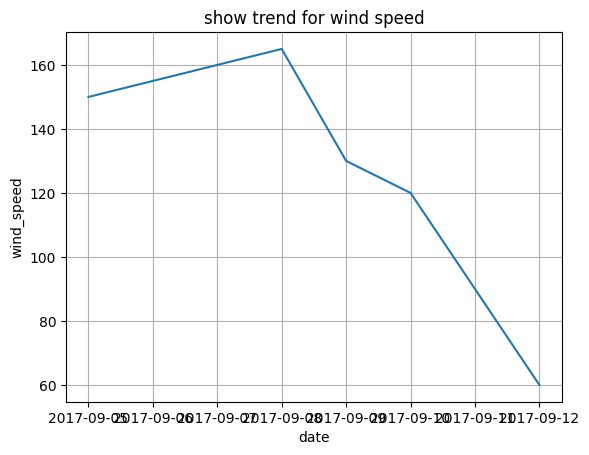

{
  "id": "ce7279e98cb04196bfd3c41cc05d845b",
  "query": "show trend for wind speed",
  "allowed": true,
  "reason": "",
  "route": "viz",
  "result": {
    "plot": {
      "path": "visual_outputs/fig_a131847b.png",
      "latency_s": 0.082
    },
    "spec": {
      "x": "date",
      "y": "wind_speed",
      "y2": "",
      "kind": "line",
      "title": "show trend for wind speed"
    }
  },
  "latency_s": 0.629
}

>>> plot rainfall vs pressure as bar


<Figure size 640x480 with 0 Axes>

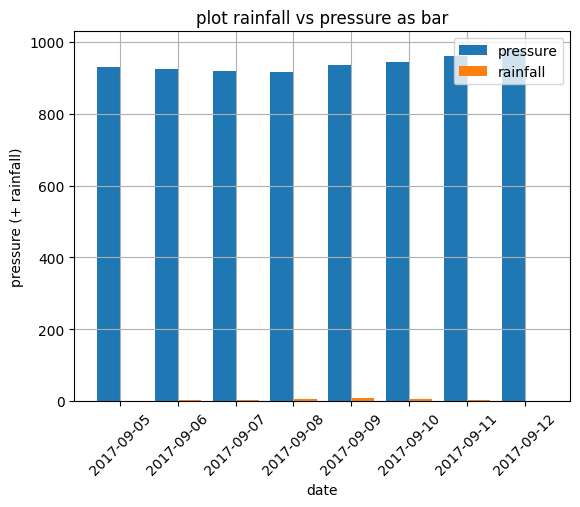

{
  "id": "5e876296e04b4150a65ef5a01f39e814",
  "query": "plot rainfall vs pressure as bar",
  "allowed": true,
  "reason": "",
  "route": "viz",
  "result": {
    "plot": {
      "path": "visual_outputs/fig_8f4f409e.png",
      "latency_s": 0.141
    },
    "spec": {
      "x": "date",
      "y": "pressure",
      "y2": "rainfall",
      "kind": "bar",
      "title": "plot rainfall vs pressure as bar"
    }
  },
  "latency_s": 1.317
}

>>> record: ./sample.wav
{
  "id": "716942c4e65d48f690a6a2dc9e7fb3be",
  "query": "record: ./sample.wav",
  "allowed": true,
  "reason": "",
  "route": "speech",
  "result": {
    "stt": {
      "engine": "whisper",
      "text": "",
      "latency_s": 0.003,
      "error": "No module named 'whisper'"
    },
    "qa": {
      "answer": "Hurricane Irma (2017) impacted Florida with strong winds, surge, flooding, and prolonged outages. Ask about landfall dates, locations, damages, or preparedness details.",
      "latency_s": 0.0,
      "context_used": []


In [8]:
tests = [
    "show trend for wind speed",
    "plot rainfall vs pressure as bar",
    "record: ./sample.wav",   # replace with your real path in Colab/Local
    "When did Irma make landfall in Florida?",
    "explain damages and costs from Irma in Florida"
]

results = []
for q in tests:
    print(f"\n>>> {q}")
    r = route(q)
    print(json.dumps(r, indent=2))
    results.append(r)



## Trace Summary
This cell loads the JSONL trace file and shows a quick tabular summary.


In [9]:
import json, pandas as pd
rows = []
p = LOGS/"router_traces.jsonl"
if p.exists():
    for line in open(p):
        try:
            rows.append(json.loads(line))
        except Exception:
            pass
pd.DataFrame(rows)[["id","query","route","latency_s","allowed","reason"]].tail()


,id,query,route,latency_s,allowed,reason
0,ce7279e98cb04196bfd3c41cc05d845b,show trend for wind speed,viz,0.629,True,
1,5e876296e04b4150a65ef5a01f39e814,plot rainfall vs pressure as bar,viz,1.317,True,
2,716942c4e65d48f690a6a2dc9e7fb3be,record: ./sample.wav,speech,0.005,True,
3,214ccc3c24714516a9a38797e4b12652,When did Irma make landfall in Florida?,qa,0.000,True,
4,d97e4940a1b44da6b89d788576ec9ff2,explain damages and costs from Irma in Florida,qa,0.000,True,



### Notes
- **Speech** requires `openai-whisper` and `gTTS`. If not installed, the speech branch returns an error but the router still logs the trace.
- **Visualization** saves plots in `visual_outputs/` and displays inline.
- **Guardrails** are keyword and length based; extend the blocklist or add regex as needed.
